In [1]:
#load libraries
import pandas as pd
import os
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima   


C:\Users\User\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Data Preprocessing

In [2]:
pwd

'C:\\Users\\User'

In [3]:
#load folder-the actual data were given in 17 separate excel files
files = os.listdir('dataLoad')
files

['Cons_Report_012018.xlsx',
 'Cons_Report_012019.xlsx',
 'Cons_Report_022018.xlsx',
 'Cons_Report_022019.xlsx',
 'Cons_Report_032018.xlsx',
 'Cons_Report_032019.xlsx',
 'Cons_Report_042018.xlsx',
 'Cons_Report_042019.xlsx',
 'Cons_Report_052018.xlsx',
 'Cons_Report_052019.xlsx',
 'Cons_Report_062018.xlsx',
 'Cons_Report_062019.xlsx',
 'Cons_Report_072018.xlsx',
 'Cons_Report_072019.xlsx',
 'Cons_Report_082018.xlsx',
 'Cons_Report_092018.xlsx',
 'Cons_Report_102018.xlsx',
 'Cons_Report_112018.xlsx',
 'Cons_Report_122018.xlsx',
 'Load Demand_Forecast.xlsx']

In [4]:
#list of files to loop-only xlsx
files_xls = [f for f in files if 'Cons_Report' in f]
files_xls

['Cons_Report_012018.xlsx',
 'Cons_Report_012019.xlsx',
 'Cons_Report_022018.xlsx',
 'Cons_Report_022019.xlsx',
 'Cons_Report_032018.xlsx',
 'Cons_Report_032019.xlsx',
 'Cons_Report_042018.xlsx',
 'Cons_Report_042019.xlsx',
 'Cons_Report_052018.xlsx',
 'Cons_Report_052019.xlsx',
 'Cons_Report_062018.xlsx',
 'Cons_Report_062019.xlsx',
 'Cons_Report_072018.xlsx',
 'Cons_Report_072019.xlsx',
 'Cons_Report_082018.xlsx',
 'Cons_Report_092018.xlsx',
 'Cons_Report_102018.xlsx',
 'Cons_Report_112018.xlsx',
 'Cons_Report_122018.xlsx']

In [5]:
#create one dataframe from all the excel files
actual = pd.DataFrame()
for f in files_xls:
    data = pd.read_excel('dataLoad/' + f)
    actual=actual.append(data, ignore_index=True)

In [6]:
#get column names
actual.columns

Index(['deliveryDay', 'Hour_EET', 'Gen_Aux', 'HV', 'Pump', 'TEL_MV', 'Network',
       'Total'],
      dtype='object')

In [7]:
#rename columns
actual.columns=['Date','Hour','Gen_Aux', 'HV', 'Pump', 'TEL_MV', 'Network','ActualTotal']
actual.head()

,Date,Hour,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal
0,2018-01-01,1,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918
1,2018-01-01,2,40.928810,760.024989,0.000,589.266551,4205.128845,5006.082645
2,2018-01-01,3,39.286246,750.624526,0.000,585.334471,4116.742544,4906.653316
3,2018-01-01,4,38.678094,756.567856,0.120,582.210175,3833.136857,4628.502808
4,2018-01-01,5,37.498531,731.949138,130.176,581.251131,3608.455842,4508.079510


- Date,Hour=Ημερομηνια Αναφοράς
- Gen_Aux=φορτιο παραγωγής μονάδων
- HV=Φορτίο Υψηλής τάσης
- Pump=Αναμενω ενημέρωση
- Network (ΜΤ+ΧΤ)= μας δίνει το συνολικό actual φορτίο
- TEL_MV=Φορτιο της τηλεμετρουμενης μεσης τασης.
- ΧΤ= Η στηλη που δημιουργώ αφαιρώντας την τηλεμετρουμενη ΜΤ από το Network και βρίσκω την actual total XT που θέλω να προβλεψω.
- ActualTotal= Το αθροισμα των Network+HV+Gen_Aux+Pump που μας δίνει το συνολικό φορτίο. Αυτό θα το χρησιμοποιήσω αργότερα για να βρω τι ποσοστό είναι η ΧΤ σε σχέση με το ActualTotal.



In [8]:
#load excel with forecast of the current program
forecast=pd.read_excel("dataLoad/Load Demand_Forecast.xlsx")

In [9]:
forecast.head()

,Year,Month,Weekday,Holiday,Date,1,2,3,4,5,...,21,22,23,24,Sum,Avrg,Max,Min,Δ vs D-1,Δ vs D-7
0,2018,1,1,1,2018-01-01,5315.0,4963.0,4838.0,4515.0,4280.0,...,6198.0,6021.0,5756.0,5513.0,127512.0,5313.000000,6237.0,4182.0,-0.112966,-0.077077
1,2018,1,2,0,2018-01-02,5023.0,4612.0,4573.0,4389.0,4250.0,...,6831.0,6517.0,6106.0,5717.0,135940.0,5664.166667,6927.0,4250.0,0.066096,-0.011101
2,2018,1,3,0,2018-01-03,5211.0,4761.0,4721.0,4547.0,4438.0,...,7409.0,6949.0,6411.0,5962.0,146200.0,6091.666667,7554.0,4438.0,0.075474,-0.001666
3,2018,1,4,0,2018-01-04,5307.0,4788.0,4721.0,4525.0,4427.0,...,7483.0,7014.0,6476.0,6038.0,149234.0,6218.083333,7649.0,4427.0,0.020752,0.020194
4,2018,1,5,0,2018-01-05,5420.0,4932.0,4865.0,4718.0,4621.0,...,7453.0,6984.0,6455.0,6037.0,149052.0,6210.500000,7550.0,4621.0,-0.001220,0.010892


In [10]:
#data manipulation to create new dataframe
forecast2=forecast[['Weekday',  'Holiday','Date', 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]]
prediction = pd.melt(forecast2, id_vars=["Weekday", "Holiday", "Date"])
prediction.head(10)

,Weekday,Holiday,Date,variable,value
0,1,1,2018-01-01,1,5315.0
1,2,0,2018-01-02,1,5023.0
2,3,0,2018-01-03,1,5211.0
3,4,0,2018-01-04,1,5307.0
4,5,0,2018-01-05,1,5420.0
5,6,1,2018-01-06,1,5430.0
6,7,0,2018-01-07,1,5348.0
7,1,0,2018-01-08,1,5170.0
8,2,0,2018-01-09,1,5343.0
9,3,0,2018-01-10,1,5304.0


In [11]:
prediction.tail(10)

,Weekday,Holiday,Date,variable,value
17510,7,0,2019-12-22,24,NaN
17511,1,0,2019-12-23,24,NaN
17512,2,0,2019-12-24,24,NaN
17513,3,1,2019-12-25,24,NaN
17514,4,1,2019-12-26,24,NaN
17515,5,0,2019-12-27,24,NaN
17516,6,0,2019-12-28,24,NaN
17517,7,0,2019-12-29,24,NaN
17518,1,0,2019-12-30,24,NaN
17519,2,0,2019-12-31,24,NaN


In [12]:
#rename columns
prediction.columns=[ 'Weekday', 'Holiday', 'Date', 'Hour', 'ForecastTotalLoad' ]
prediction.head(10)

,Weekday,Holiday,Date,Hour,ForecastTotalLoad
0,1,1,2018-01-01,1,5315.0
1,2,0,2018-01-02,1,5023.0
2,3,0,2018-01-03,1,5211.0
3,4,0,2018-01-04,1,5307.0
4,5,0,2018-01-05,1,5420.0
5,6,1,2018-01-06,1,5430.0
6,7,0,2018-01-07,1,5348.0
7,1,0,2018-01-08,1,5170.0
8,2,0,2018-01-09,1,5343.0
9,3,0,2018-01-10,1,5304.0


In [13]:
#subtract one hour to get to 0-23 hour format
actual['Hour']=actual['Hour']-1
prediction['Hour']=prediction['Hour']-1

- ForecastTotalLoad είναι η προβλεψη για το συνολικό actual φορτίο όπως την κάνουν τωρα και πρέπει να συγκριθεί με την αντίστοιχη τιμή πιο πανω του ActualTotal.

In [14]:
#set index
actual.set_index(['Date', 'Hour']).head()

Gen_Aux          HV     Pump      TEL_MV      Network  \
Date       Hour                                                            
2018-01-01 0     34.418093  757.020147    0.000  596.563993  4529.773678   
           1     40.928810  760.024989    0.000  589.266551  4205.128845   
           2     39.286246  750.624526    0.000  585.334471  4116.742544   
           3     38.678094  756.567856    0.120  582.210175  3833.136857   
           4     37.498531  731.949138  130.176  581.251131  3608.455842   

                 ActualTotal  
Date       Hour               
2018-01-01 0     5321.211918  
           1     5006.082645  
           2     4906.653316  
           3     4628.502808  
           4     4508.079510

In [15]:
#set index
prediction.set_index(['Date', 'Hour']).head()

,,Weekday,Holiday,ForecastTotalLoad
Date,Hour,,,
2018-01-01,0,1,1,5315.0
2018-01-02,0,2,0,5023.0
2018-01-03,0,3,0,5211.0
2018-01-04,0,4,0,5307.0
2018-01-05,0,5,0,5420.0


* Join the two dataframes.

In [16]:
#merge datasets
final = pd.merge(prediction, actual, on=['Date', 'Hour'])
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918
1,2,0,2018-01-02,0,5023.0,45.218816,751.513843,0.000,610.814364,4101.718326,4898.450985
2,3,0,2018-01-03,0,5211.0,37.042898,904.679508,0.000,800.563658,4283.392261,5225.114667
3,4,0,2018-01-04,0,5307.0,35.636497,918.203986,0.000,853.288369,4450.591164,5404.431647
4,5,0,2018-01-05,0,5420.0,37.712368,961.116481,23.108,866.047536,4617.594242,5639.531090


In [17]:
#create Timestamp column
final['Timestamp'] = final['Date'] + pd.to_timedelta(final['Hour'], unit='h')
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918,2018-01-01
1,2,0,2018-01-02,0,5023.0,45.218816,751.513843,0.000,610.814364,4101.718326,4898.450985,2018-01-02
2,3,0,2018-01-03,0,5211.0,37.042898,904.679508,0.000,800.563658,4283.392261,5225.114667,2018-01-03
3,4,0,2018-01-04,0,5307.0,35.636497,918.203986,0.000,853.288369,4450.591164,5404.431647,2018-01-04
4,5,0,2018-01-05,0,5420.0,37.712368,961.116481,23.108,866.047536,4617.594242,5639.531090,2018-01-05


In [18]:
#sort by timestamp
final.sort_values('Timestamp', inplace=True)
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918,2018-01-01 00:00:00
577,1,1,2018-01-01,1,4963.0,40.928810,760.024989,0.000,589.266551,4205.128845,5006.082645,2018-01-01 01:00:00
1154,1,1,2018-01-01,2,4838.0,39.286246,750.624526,0.000,585.334471,4116.742544,4906.653316,2018-01-01 02:00:00
1731,1,1,2018-01-01,3,4515.0,38.678094,756.567856,0.120,582.210175,3833.136857,4628.502808,2018-01-01 03:00:00
2308,1,1,2018-01-01,4,4280.0,37.498531,731.949138,130.176,581.251131,3608.455842,4508.079510,2018-01-01 04:00:00


In [19]:
final.tail()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
11539,3,0,2019-07-31,19,7931.0,16.363664,795.291050,0.0,1707.609708,7110.765617,7922.420331,2019-07-31 19:00:00
12116,3,0,2019-07-31,20,7849.0,13.973660,792.197895,0.0,1648.980593,7058.939398,7865.110953,2019-07-31 20:00:00
12693,3,0,2019-07-31,21,7999.0,14.895003,794.864766,0.0,1551.325953,7249.907263,8059.667031,2019-07-31 21:00:00
13270,3,0,2019-07-31,22,7668.0,16.852303,768.847863,0.0,1413.018165,6891.037129,7676.737295,2019-07-31 22:00:00
13845,3,0,2019-07-31,23,7348.0,15.590655,898.400449,0.0,1341.926612,6488.048163,7402.039267,2019-07-31 23:00:00


In [20]:
#create the column of interest
final['XT'] = final['Network'] - final['TEL_MV']

#find the percentage of XT as to total ActualLoad for that day and Hour (TrueValues)
final['%XTofTotal']=final['XT']/final['ActualTotal']

#find the estimation of XTPrediction
final['XTForecastEstimation']=final['%XTofTotal']*final['ForecastTotalLoad']


Στο παραπάνω κελι αφού δημιουργήσω τη στηλη με τις actual τιμές της ΧΤ υπολογίζω το ποσοστό που έπιανε η ΧΤ σε σχέση με το σύνολο του φορτίου για εκείνη τη μέρα ώρα. Βρίσκοντας το ποσοστό, το εφαρμόζω μετά στην πρόβλεψη που δίνει το μοντέλο τους (το μοντέλο τους προβλέπει το σύνολικό φορτίο του δυκτίου) για να μπορέσω να προσεγγίσω την πρόβλεψη του μοντέλου αν προέβλεπε τη χαμηλή τάση. Θα το χρησιμοποιήσω στη σύγκριση μεταξυ του δικού μας και του δικού τους μοντέλου όπως είπαμε.

In [21]:
#finalize dataset and set frequency
final=final[['Timestamp','XT','Weekday','Holiday','XTForecastEstimation']]
final.sort_values('Timestamp', inplace=True)
final.set_index('Timestamp', inplace=True)

In [22]:
final

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2018-01-01 00:00:00,3933.209685,1,1,3928.618104
2018-01-01 01:00:00,3615.862294,1,1,3584.743969
2018-01-01 02:00:00,3531.408073,1,1,3481.997027
2018-01-01 03:00:00,3250.926682,1,1,3171.205588
2018-01-01 04:00:00,3027.204711,1,1,2874.047836
...,...,...,...,...
2019-07-31 19:00:00,5403.155909,3,0,5409.007315
2019-07-31 20:00:00,5409.958805,3,0,5398.877004
2019-07-31 21:00:00,5698.581309,3,0,5655.686732


* Check the index for the frequency (should be hourly).

In [23]:
final.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2019-07-31 14:00:00', '2019-07-31 15:00:00',
               '2019-07-31 16:00:00', '2019-07-31 17:00:00',
               '2019-07-31 18:00:00', '2019-07-31 19:00:00',
               '2019-07-31 20:00:00', '2019-07-31 21:00:00',
               '2019-07-31 22:00:00', '2019-07-31 23:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=13846, freq=None)

* The `None` reported value indicates that there might be missing values.

In [24]:
#check for missing values
pd.date_range(final.index.min(), final.index.max(), freq='H').difference(final.index)

DatetimeIndex(['2018-03-25 23:00:00', '2019-03-31 23:00:00'], dtype='datetime64[ns]', freq=None)

* Let's check what happens around the first date.

In [25]:
final.loc['2018-03-25':'2018-03-26']

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2018-03-25 00:00:00,3147.824162,7,1,3171.278635
2018-03-25 01:00:00,2740.862797,7,1,2745.225070
2018-03-25 02:00:00,2654.360886,7,1,2648.583949
2018-03-25 03:00:00,2507.887529,7,1,NaN
2018-03-25 04:00:00,2440.072651,7,1,2506.587454
2018-03-25 05:00:00,2515.380769,7,1,2532.772226
2018-03-25 06:00:00,2612.671803,7,1,2604.791065
2018-03-25 07:00:00,2930.827226,7,1,2807.819204
2018-03-25 08:00:00,3306.252447,7,1,3126.662986


* There is a missing from March 25 to March 26, 2018.

* Let's also check what is happening with the second date.

In [26]:
final.loc['2019-03-31':'2019-04-01']

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2019-03-31 00:00:00,3301.206709,7,0,3247.902346
2019-03-31 01:00:00,2873.602290,7,0,2819.229247
2019-03-31 02:00:00,2747.037509,7,0,2732.615475
2019-03-31 03:00:00,2588.609454,7,0,2603.115607
2019-03-31 04:00:00,2508.161442,7,0,2440.825764
2019-03-31 05:00:00,2584.451302,7,0,2492.355395
2019-03-31 06:00:00,2782.655535,7,0,2586.818830
2019-03-31 07:00:00,3116.754635,7,0,2827.044553
2019-03-31 08:00:00,3392.986697,7,0,3069.195420


* Same story, an hour was skipped between March 31 and April 1, 2019.

* We'll fix the issue by using the previous value.

In [27]:
#set Hourly index frequency
final = final.asfreq(freq='H', method='pad')
final.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2019-07-31 14:00:00', '2019-07-31 15:00:00',
               '2019-07-31 16:00:00', '2019-07-31 17:00:00',
               '2019-07-31 18:00:00', '2019-07-31 19:00:00',
               '2019-07-31 20:00:00', '2019-07-31 21:00:00',
               '2019-07-31 22:00:00', '2019-07-31 23:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=13848, freq='H')

In [28]:
#check again for NaN in dataframe γιατι τώρα που κουβαλάω και την επιπλέον στήλη εχω το ίδιο θέμα με την ώρα
final[final.isnull().any(axis=1)]

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2018-03-25 03:00:00,2507.887529,7,1,NaN


In [29]:
#NaN that day for forecastedValues
final.loc['2018-03-25 03:00:00']

XT                      2507.887529
Weekday                    7.000000
Holiday                    1.000000
XTForecastEstimation            NaN
Name: 2018-03-25 03:00:00, dtype: float64

In [30]:
#fill with previous value ΝαΝ
final=final.fillna(method='ffill')

In [31]:
#fixed
final.loc['2018-03-25 03:00:00']

XT                      2507.887529
Weekday                    7.000000
Holiday                    1.000000
XTForecastEstimation    2648.583949
Name: 2018-03-25 03:00:00, dtype: float64

# Data Exploration

In [32]:
#Here is going to be the EDA part-just some quick insights

Text(0.5, 1.0, 'Low Voltage Consumption VS Holiday')

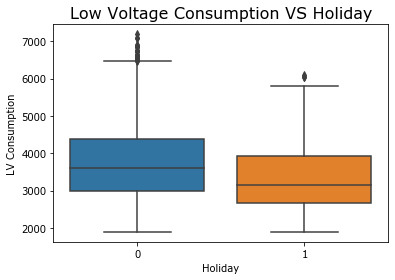

In [33]:
import seaborn as sns
sns.boxplot(x=final['Holiday'],y=final['XT']).set(ylabel='LV Consumption',xlabel='Holiday')
plt.title('Low Voltage Consumption VS Holiday',fontsize=16)

Text(0.5, 1.0, 'Low Voltage Consumption VS Weekday')

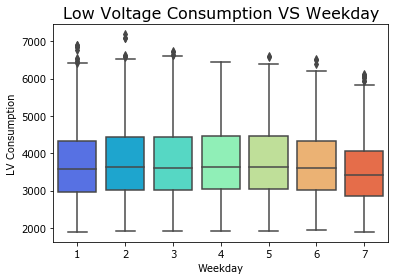

In [34]:
sns.boxplot(x=final['Weekday'],y=final['XT'],palette='rainbow').set(ylabel='LV Consumption',xlabel='Weekday')
plt.title('Low Voltage Consumption VS Weekday',fontsize=16)

Text(0.5, 1.0, 'Low Voltage Consumption')

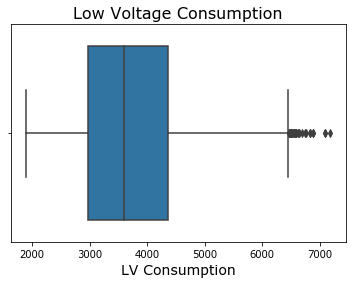

In [35]:
#there are some outliers
sns.boxplot(x=final['XT']).set_xlabel('LV Consumption',fontsize=14)
plt.title('Low Voltage Consumption',fontsize=16)


In [36]:
#check largest Values-seems logical not extreme values
print( final['XT'].nlargest(100))

Timestamp
2019-01-08 19:00:00    7187.273484
2019-01-08 18:00:00    7092.001648
2019-01-08 20:00:00    7087.291997
2019-01-07 19:00:00    6889.243639
2018-12-31 19:00:00    6886.460958
                          ...     
2019-07-09 18:00:00    6106.338999
2018-01-26 19:00:00    6104.612583
2019-01-07 11:00:00    6104.174324
2019-01-04 16:00:00    6103.586724
2018-01-25 18:00:00    6100.779307
Name: XT, Length: 100, dtype: float64


Text(0.5, 1.0, 'Daily Actual Consumption per Hour')

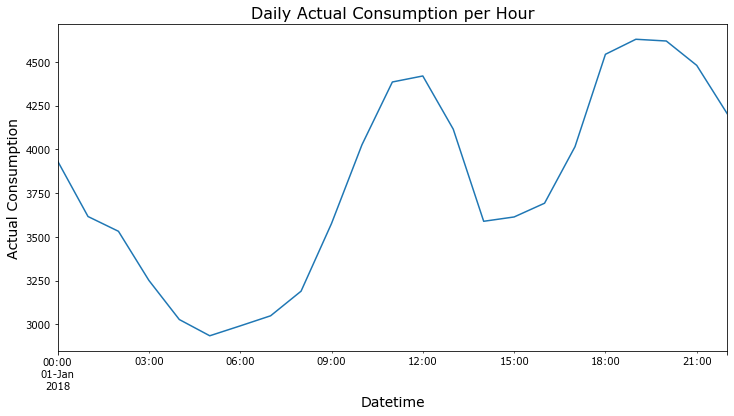

In [37]:
final['XT'].iloc[:23].plot(figsize=(12,6)).autoscale(axis='x',tight=True);
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Actual Consumption', fontsize=14)
plt.title('Daily Actual Consumption per Hour', fontsize=16)

Text(0.5, 1.0, 'Actual Consumption (Historical Data)')

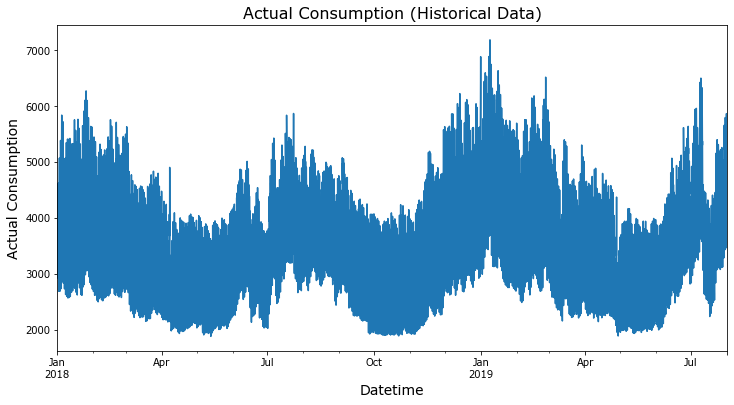

In [38]:
final['XT'].plot(figsize=(12,6)).autoscale(axis='x',tight=True);
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Actual Consumption', fontsize=14)
plt.title('Actual Consumption (Historical Data)', fontsize=16)

Text(0, 0.5, 'Residual')

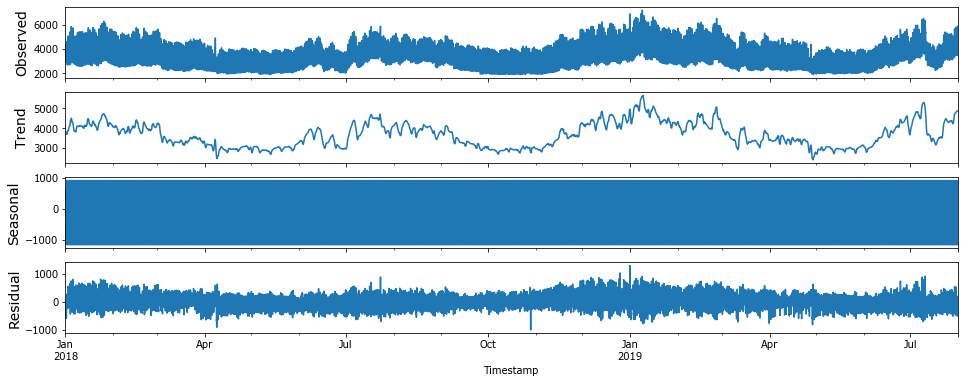

In [39]:
fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(16,6))

result = seasonal_decompose(final['XT'])

result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed',fontsize=14)
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend',fontsize=14)
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal',fontsize=14)
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual',fontsize=14)


# SARIMAX

In [40]:
#create ad-fuller test function
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [41]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

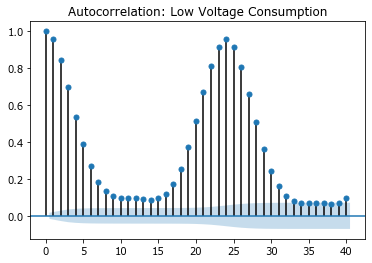

In [42]:
# Now let's plot the autocorrelation at different lags
title = 'Autocorrelation: Low Voltage Consumption'
lags = 40
plot_acf(final['XT'],title=title,lags=lags);

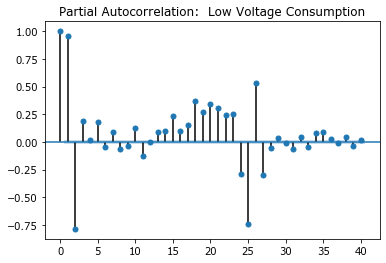

In [43]:
title='Partial Autocorrelation:  Low Voltage Consumption'
lags=40
plot_pacf(final['XT'],title=title,lags=lags);

In [44]:
#KPSS test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(series):
    print ('Results of KPSS Test:')
    kpsstest = kpss(series, regression='c', lags='auto')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [45]:
kpss_test(final['XT'])

Results of KPSS Test:
Test Statistic            1.019992
p-value                   0.010000
Lags Used                55.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [46]:
adf_test(final['XT'])

Augmented Dickey-Fuller Test: 
ADF test statistic         -3.871747
p-value                     0.002253
# lags used                42.000000
# observations          13805.000000
critical value (1%)        -3.430824
critical value (5%)        -2.861749
critical value (10%)       -2.566881
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [47]:
final2=final

In [48]:
final2

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2018-01-01 00:00:00,3933.209685,1,1,3928.618104
2018-01-01 01:00:00,3615.862294,1,1,3584.743969
2018-01-01 02:00:00,3531.408073,1,1,3481.997027
2018-01-01 03:00:00,3250.926682,1,1,3171.205588
2018-01-01 04:00:00,3027.204711,1,1,2874.047836
...,...,...,...,...
2019-07-31 19:00:00,5403.155909,3,0,5409.007315
2019-07-31 20:00:00,5409.958805,3,0,5398.877004
2019-07-31 21:00:00,5698.581309,3,0,5655.686732


In [49]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(final['XT'].loc['2018-05-01':'2019-07-31'], seasonal=True, m=24).summary()

KeyboardInterrupt: 

In [50]:
#use the period used for training
df1=final.loc['2018-01-01':'2019-07-31']
df1.shape

(13848, 4)

* Use all data except the last two days for training and the last two days for testing.

In [51]:
#train test split
train = df1.iloc[:-24*2]
test = df1.iloc[-24*2:]

In [53]:
#run model
model = SARIMAX(train['XT'],
                exog=train[['Holiday','Weekday']],
                order=(2, 1, 2),
                seasonal_order=(2, 0, 2, 24),initialization='approximate_diffuse',
                enforce_invertibility=False)
results = model.fit()
results.summary()

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                 XT   No. Observations:                13800
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 24)   Log Likelihood              -76021.422
Date:                            Sun, 15 Sep 2019   AIC                         152064.844
Time:                                    15:42:00   BIC                         152147.699
Sample:                                01-01-2018   HQIC                        152092.447
                                     - 07-29-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday       27.7463      4.891      5.673      0.000      18.161      37.332
Weekday       -0.9570      0.830     -1.153      0.249      -2.583       0.669
ar.L1         -0.5281      0.198     -2.667      0.008      -0.916      -0.140
ar.L2          0.3019      0.071      4.228      0.000       0.162       0.442
ma.L1          3.3827      0.258     13.119      0.000       2.877       3.888
ma.L2          2.1873      0.553      3.953      0.000       1.103       3.272
ar.S.L24       0.0029      0.002      1.325      0.185      -0.001       0.007
ar.S.L48       0.9970      0.002    451.449      0.000       0.993       1.001
ma.S.L24       0.3490      0.452      0.772      0.440      -0.537       1.235
ma.S.L48      -0.6511      0.294     -2.212      0.027      -1.228      -0.074
sigma2       550.6479    253.567      2.172      0.030      53.666    1047.630
===================================================================================
Ljung-Box (Q):                     1806.04   Jarque-Bera (JB):            116088.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.64
Prob(H) (two-sided):                  0.29   Kurtosis:                        17.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['Holiday','Weekday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, 
                              end=end, 
                              exog=exog_forecast).rename('SARIMAX(2,1,2)(2, 0, 2, 24) Predictions')

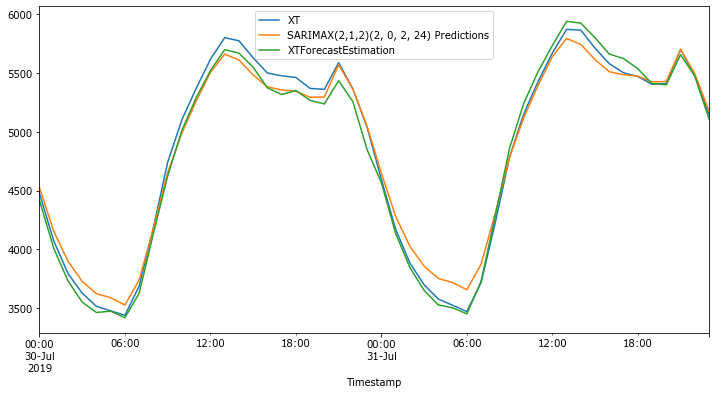

In [55]:
# Plot predictions against known values
ax = test['XT'].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
final['XTForecastEstimation'].loc['2019-07-30':'2019-07-31'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [56]:
from statsmodels.tools.eval_measures import mse,rmse
#calculate rmse
OurError= rmse(test['XT'], predictions)
TheirError = rmse(final['XTForecastEstimation'].loc['2019-07-30':'2019-07-31'], test['XT'])

In [57]:
TheirError

82.28752711748584

In [59]:

OurError

98.09998612734096

In [60]:
#create copy of df in order to make prediction for the future
#df2=final.loc['2018-05-01':'2019-05-03'].copy()

In [61]:
#set NaN to the target variable 
#df2.loc['2019-05-02':'2019-05-03', 'XT'] = np.NaN

In [62]:
#retrain of full dataset
#model = SARIMAX(df1['XT'],
                #exog=df1[['Weekday','Holiday']],
                #order=(1,1,0),
               # seasonal_order=(2,0,1,24),
               # enforce_invertibility=False)

In [63]:
#results = model.fit()

In [64]:
#get the future data for holidays and weekday
#exog_forecast = df2.iloc[len(df1):][['Holiday','Weekday']]

In [65]:
#make forcast for 2 days ahead
#fcast = results.predict(len(df1),len(df1)+47,exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Forecast')

In [66]:
# Plot predictions against known values
#ax = fcast.plot(legend=True,figsize=(12,6))
#final['XTForecastEstimation'].loc['2019-05-02':'2019-05-03'].plot(legend=True)
#final['XT'].loc['2019-05-02':'2019-05-03'].plot(legend=True)
#ax.autoscale(axis='x',tight=True)

In [67]:
#from statsmodels.tools.eval_measures import mse,rmse
#calculate error
#OurError= rmse(final['XT'].loc['2019-05-02':'2019-05-03'], fcast)
#TheirError = rmse(final['XT'].loc['2019-05-02':'2019-05-03'], final['XTForecastEstimation'].loc['2019-05-02':'2019-05-03'])

In [68]:
#WinAgain
#OurError

In [69]:
#FairlyClose
#TheirError

# Prophet

In [93]:
#import ProphetLibrary
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [94]:
#create holidays Dataframe for possible use by Prophet
holidays = pd.DataFrame({
    'ds': train.reset_index().query('Holiday == 1')['Timestamp'],
    'holiday': 'holiday'
})
holidays.head()

In [95]:
#fit Prophet model
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)#, holidays=holidays)
prophet_model.fit(train['XT'].reset_index().rename(columns={'Timestamp':'ds', 'XT':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\Users\ntarz\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [96]:
#predict
prophet_forecast = prophet_model.predict(df=test['XT'].reset_index().rename(columns={'Timestamp':'ds'}))

In [97]:
#store predictions
_ = prophet_model.plot_components(prophet_forecast)

In [ ]:
# Plot predictions against known values
fig, axes = plt.subplots(1, figsize=(16,6))
axes.plot(test.index, test['XT'], label='XT')
axes.plot(test.index, prophet_forecast['yhat'], label='Prophet', axes=axes)
final['XTForecastEstimation'].loc['2019-04-30':'2019-05-01'].plot(legend=True, axes=axes)
axes.autoscale(axis='x', tight=True)
axes.legend()

In [98]:
#calculate Error
from statsmodels.tools.eval_measures import mse,rmse
prophet_error= rmse(test['XT'], prophet_forecast['yhat'])

In [99]:
#worse
prophet_error

330.97786559210465

# RNN Keras (Univariate)

In [70]:
final2=final['XT']
final2=pd.DataFrame(final2)
final2.head()

,XT
Timestamp,
2018-01-01 00:00:00,3933.209685
2018-01-01 01:00:00,3615.862294
2018-01-01 02:00:00,3531.408073
2018-01-01 03:00:00,3250.926682
2018-01-01 04:00:00,3027.204711


In [71]:
import pandas as pd
import numpy as np
import tensorflow as tf

import time
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [72]:
tf.enable_eager_execution()
tf.executing_eagerly()

True

In [73]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
input_data= sc.fit_transform(final2)

In [74]:
TRAIN_SPLIT = input_data.shape[0] * 2 // 3
TRAIN_SPLIT

9232

In [75]:
STEP = 1 # We are going to use all samples

In [76]:
def univariate_data(dataset,start_index, end_index, 
                      history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i:i+target_size])

    return np.array(data), np.array(labels)

In [77]:
past_history = 10 * 24
future_target = 2 * 24

In [78]:
x_train_uni, y_train_uni = univariate_data(input_data[:,0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target)
x_val_uni, y_val_uni = univariate_data(input_data[:,0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target)

In [79]:
print ('Single window of past history : {}'.format(x_train_uni[0].shape))
print ('Target load to predict : {}'.format(y_train_uni[0].shape))

Single window of past history : (240, 1)
Target load to predict : (48,)


In [80]:
BATCH_SIZE = 256
BUFFER_SIZE = x_train_uni.shape[0]
BUFFER_SIZE

8992

In [81]:
train_data_uni = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_data_uni = train_data_uni.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_uni = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_data_uni = val_data_uni.batch(BATCH_SIZE).repeat()

In [82]:
def multi_step_plot_uni(history, true_future, prediction):
    plt.figure(figsize=(16, 10))
    num_in = [ x for x in range(-int(history.shape[0]), 0, 1)]
    num_out = int(true_future.shape[0])

    plt.plot(num_in, np.array(history), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 
             color='green',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 
                 color='brown',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

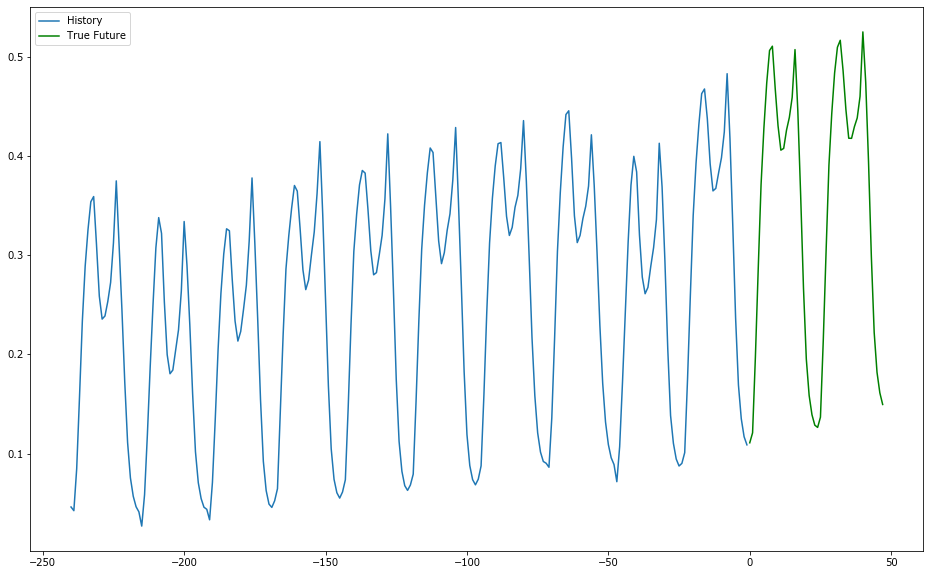

In [83]:
for x, y in train_data_uni.take(1):
    multi_step_plot_uni(x[0], y[0], np.array([0]))

In [84]:
univariate_model = tf.keras.models.Sequential()
univariate_model.add(tf.keras.layers.LSTM(units=100, return_sequences=True, 
                                            input_shape=x_train_uni.shape[-2:]))
univariate_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
#univariate_model.add(tf.keras.layers.LSTM(units=300, return_sequences=True))
univariate_model.add(tf.keras.layers.LSTM(units=8))
univariate_model.add(tf.keras.layers.Dense(units=48))
univariate_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 240, 100)          40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 240, 50)           30200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 1888      
_________________________________________________________________
dense (Dense)                (None, 48)                432       
Total params: 73,320
Trainable params: 73,320
Non-trainable params: 0
_________________________________________________________________


In [85]:
len(final2)

13848

In [86]:
univariate_model.compile(optimizer='adam', loss='mean_squared_error')

In [87]:
for x, y in val_data_uni.take(1):
    print (univariate_model.predict(x).shape)

(256, 48)


In [88]:
univariate_history = univariate_model.fit(train_data_uni, 
                                              epochs=10,
                                              steps_per_epoch=x_train_uni.shape[0] / BATCH_SIZE,
                                              validation_data=val_data_uni,
                                              validation_steps=50)

Epoch 1/10


W0915 15:58:45.850560 10832 deprecation.py:323] From C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


36/35 [==============================] - 108s 3s/step - loss: 0.1165 - val_loss: 0.0835
Epoch 2/10
36/35 [==============================] - 96s 3s/step - loss: 0.0615 - val_loss: 0.0412
Epoch 3/10
36/35 [==============================] - 99s 3s/step - loss: 0.0316 - val_loss: 0.0242
Epoch 4/10
36/35 [==============================] - 104s 3s/step - loss: 0.0218 - val_loss: 0.0199
Epoch 5/10
36/35 [==============================] - 107s 3s/step - loss: 0.0188 - val_loss: 0.0185
Epoch 6/10
36/35 [==============================] - 112s 3s/step - loss: 0.0171 - val_loss: 0.0168
Epoch 7/10
36/35 [==============================] - 118s 3s/step - loss: 0.0156 - val_loss: 0.0154
Epoch 8/10
36/35 [==============================] - 125s 3s/step - loss: 0.0141 - val_loss: 0.0141
Epoch 9/10
36/35 [==============================] - 129s 4s/step - loss: 0.0127 - val_loss: 0.0128
Epoch 10/10
36/35 [==============================] - 133s 4s/step - loss: 0.0115 - val_loss: 0.0119


In [89]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

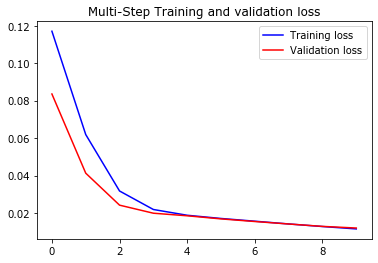

In [90]:
plot_train_history(univariate_history, 'Multi-Step Training and validation loss')

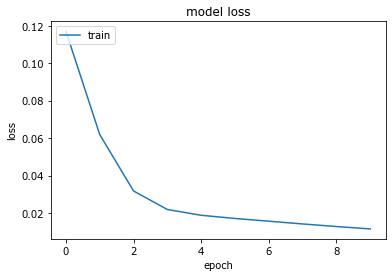

In [91]:
# summarize history for loss
plt.plot(univariate_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

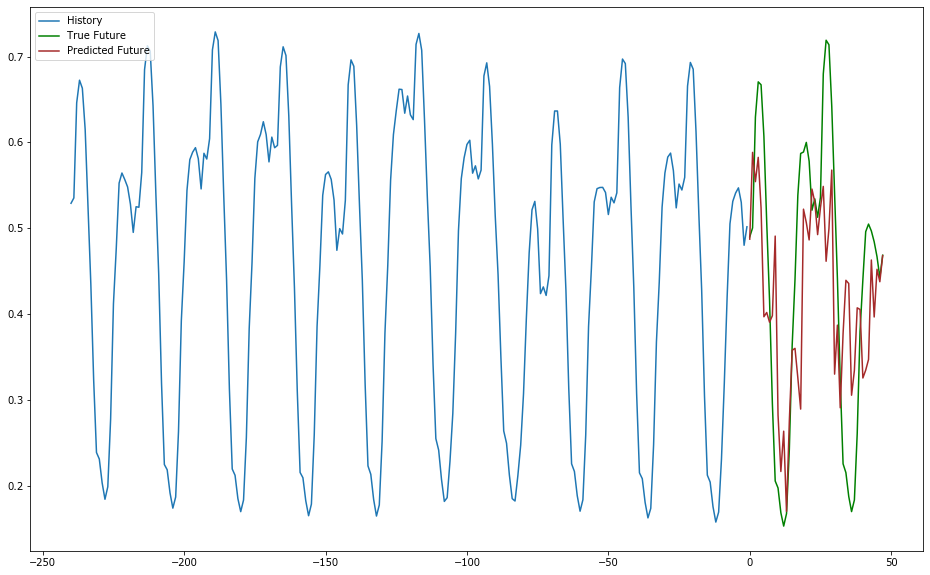

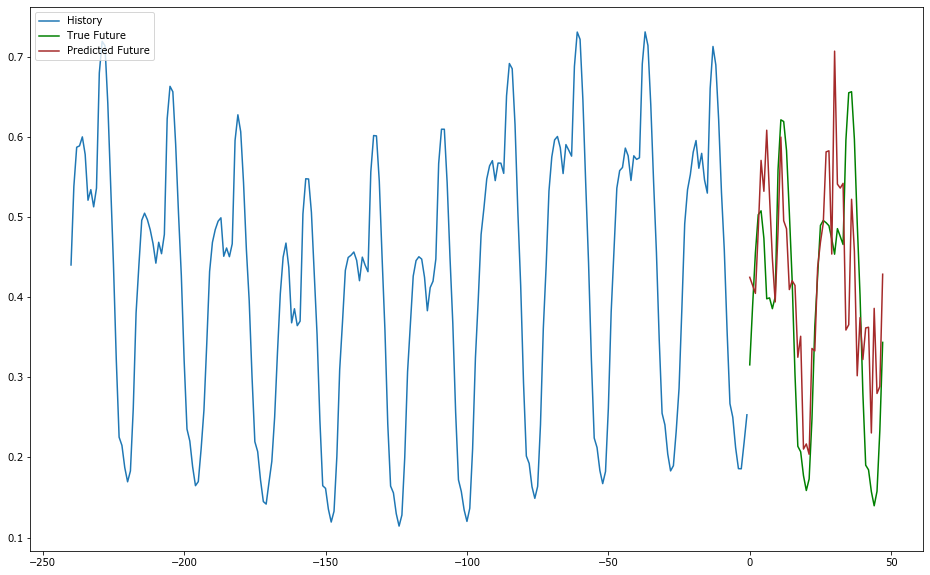

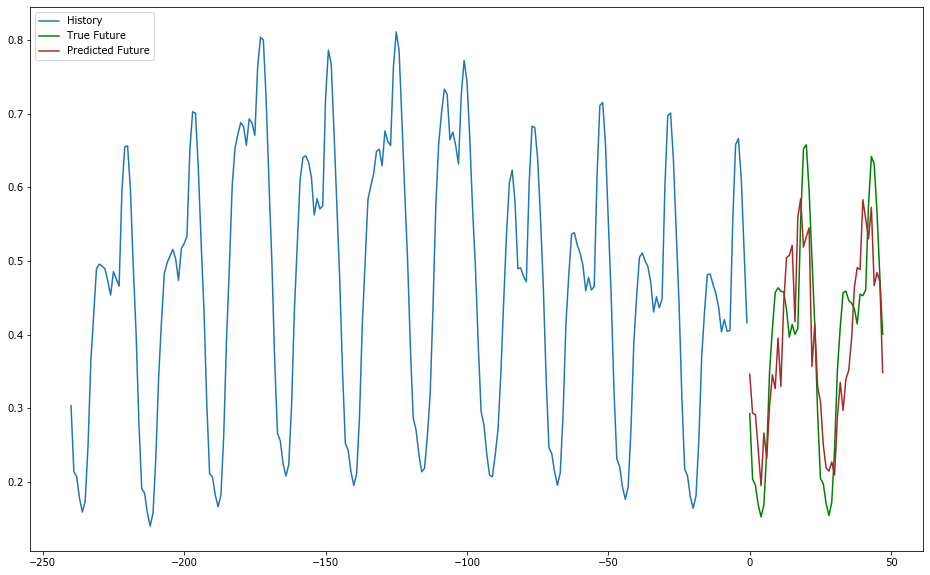

In [92]:
for x, y in val_data_uni.take(3):
    multi_step_plot_uni(x[0], y[0], univariate_model.predict(x)[0])

# RNN Keras (Multivariate)

In [93]:
import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot

In [94]:
tf.enable_eager_execution()
tf.executing_eagerly()

True

In [95]:
final_lstm_multi = final[['Weekday','XT','Holiday']]
final_lstm_multi = pd.DataFrame(final_lstm_multi)
final_lstm_multi.head()

,Weekday,XT,Holiday
Timestamp,,,
2018-01-01 00:00:00,1,3933.209685,1
2018-01-01 01:00:00,1,3615.862294,1
2018-01-01 02:00:00,1,3531.408073,1
2018-01-01 03:00:00,1,3250.926682,1
2018-01-01 04:00:00,1,3027.204711,1


In [96]:
final_lstm_multi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13848 entries, 2018-01-01 00:00:00 to 2019-07-31 23:00:00
Freq: H
Data columns (total 3 columns):
Weekday    13848 non-null int64
XT         13848 non-null float64
Holiday    13848 non-null int64
dtypes: float64(1), int64(2)
memory usage: 1.0 MB


In [97]:
final_lstm_multi['XT']

Timestamp
2018-01-01 00:00:00    3933.209685
2018-01-01 01:00:00    3615.862294
2018-01-01 02:00:00    3531.408073
2018-01-01 03:00:00    3250.926682
2018-01-01 04:00:00    3027.204711
                          ...     
2019-07-31 19:00:00    5403.155909
2019-07-31 20:00:00    5409.958805
2019-07-31 21:00:00    5698.581309
2019-07-31 22:00:00    5478.018964
2019-07-31 23:00:00    5146.121551
Freq: H, Name: XT, Length: 13848, dtype: float64

In [98]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler
ct = ColumnTransformer([
        ("weekday", OneHotEncoder(categories='auto'), [0]),
        ("xt", MinMaxScaler(feature_range=(0,1)), [1]),
        ("holiday", "passthrough", [2])],
        sparse_threshold=0)

In [99]:
dataset = ct.fit_transform(final_lstm_multi.values)
dataset[0:100:10]

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.3855027 , 1.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.40293079, 1.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.51495865, 1.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.19206572, 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.441267  , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.20653378, 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.513591  , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.50337793, 0.        ],


In [100]:
TRAIN_SPLIT = dataset.shape[0] * 2 // 3
TRAIN_SPLIT

9232

In [101]:
STEP = 1 # We are going to use all samples

In [102]:
def multivariate_data(dataset, target, start_index, end_index, 
                      history_size, target_size, 
                      step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [103]:
past_history = 10 * 24 # 10 days in the past
future_target = 2 * 24 # two days in the future

In [104]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, -2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, -2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

* Let's check a data sample.

In [105]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('Target load to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (240, 9)
Target load to predict : (48,)


In [106]:
BATCH_SIZE = 256
BUFFER_SIZE = x_train_multi.shape[0]
BUFFER_SIZE

8992

In [107]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [108]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(16, 10))
    num_in = [ x for x in range(-int(history.shape[0]), 0, 1)]
    num_out = int(true_future.shape[0])

    plt.plot(num_in, np.array(history[:, -2]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 
             color='green',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 
                 color='brown',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

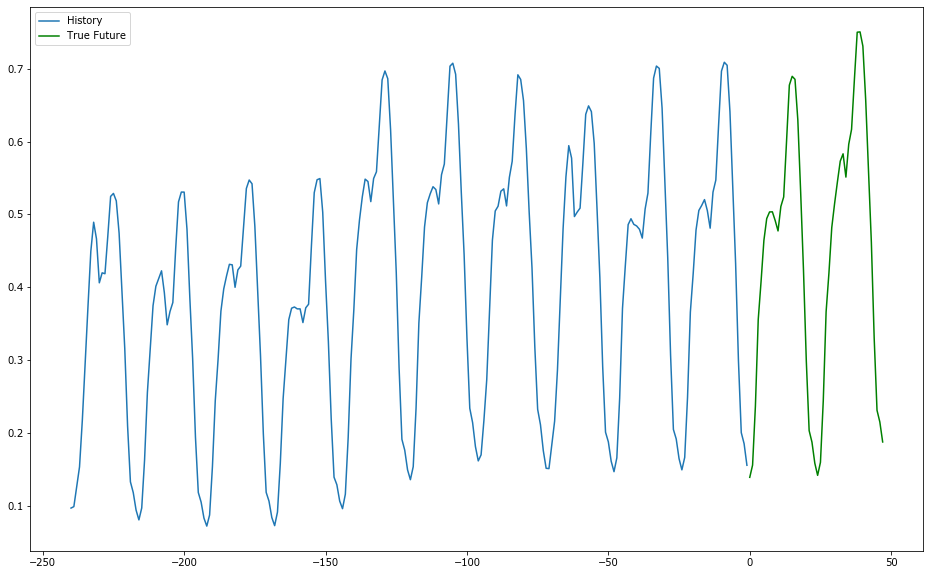

In [109]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [111]:
multivariate_model = tf.keras.models.Sequential()
multivariate_model.add(tf.keras.layers.LSTM(units=300, return_sequences=True, 
                                            input_shape=x_train_multi.shape[-2:]))
multivariate_model.add(tf.keras.layers.LSTM(units=100, return_sequences=True))
#multivariate_model.add(tf.keras.layers.LSTM(units=300, return_sequences=True))
multivariate_model.add(tf.keras.layers.LSTM(units=50))
multivariate_model.add(tf.keras.layers.Dense(units=48))
multivariate_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 240, 300)          372000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 240, 100)          160400    
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_2 (Dense)              (None, 48)                2448      
Total params: 565,048
Trainable params: 565,048
Non-trainable params: 0
_________________________________________________________________


In [112]:
multivariate_model.compile(optimizer='adam', loss='mean_squared_error')

* Let's see how the model predicts before it trains.

In [113]:
for x, y in val_data_multi.take(1):
    print (multivariate_model.predict(x).shape)

(256, 48)


In [115]:
multivariate_history = multivariate_model.fit(train_data_multi, 
                                              epochs=10,
                                              steps_per_epoch=x_train_multi.shape[0] / BATCH_SIZE,
                                              validation_data=val_data_multi,
                                              validation_steps=50)

Epoch 1/10
36/35 [==============================] - 404s 11s/step - loss: 0.0482 - val_loss: 0.0222
Epoch 2/10
36/35 [==============================] - 354s 10s/step - loss: 0.0211 - val_loss: 0.0197
Epoch 3/10
36/35 [==============================] - 358s 10s/step - loss: 0.0155 - val_loss: 0.0115
Epoch 4/10
36/35 [==============================] - 369s 10s/step - loss: 0.0081 - val_loss: 0.0084
Epoch 5/10
36/35 [==============================] - 377s 10s/step - loss: 0.0064 - val_loss: 0.0089
Epoch 6/10
36/35 [==============================] - 388s 11s/step - loss: 0.0056 - val_loss: 0.0072
Epoch 7/10
36/35 [==============================] - 404s 11s/step - loss: 0.0049 - val_loss: 0.0058
Epoch 8/10
36/35 [==============================] - 403s 11s/step - loss: 0.0039 - val_loss: 0.0054
Epoch 9/10
36/35 [==============================] - 412s 11s/step - loss: 0.0036 - val_loss: 0.0048
Epoch 10/10
36/35 [==============================] - 423s 12s/step - loss: 0.0034 - val_loss: 0.0046

In [116]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

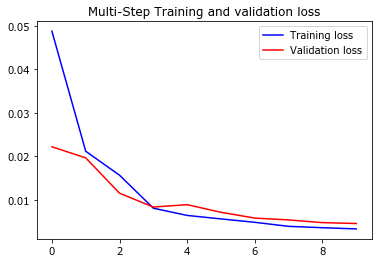

In [117]:
plot_train_history(multivariate_history, 'Multi-Step Training and validation loss')

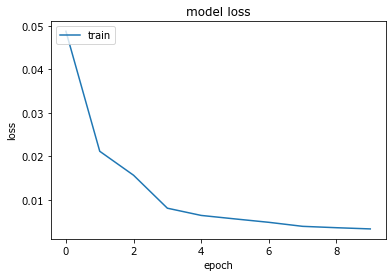

In [118]:
# summarize history for loss
plt.plot(multivariate_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

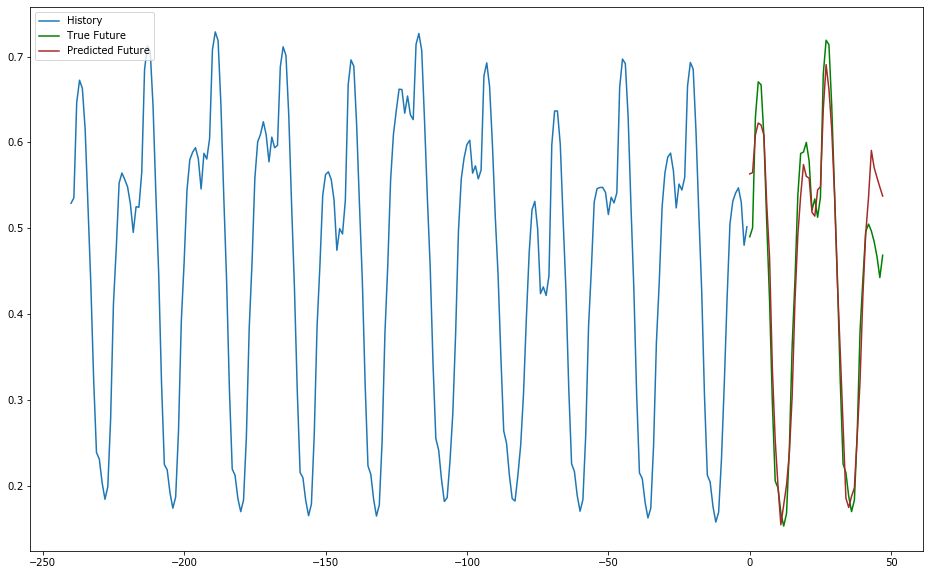

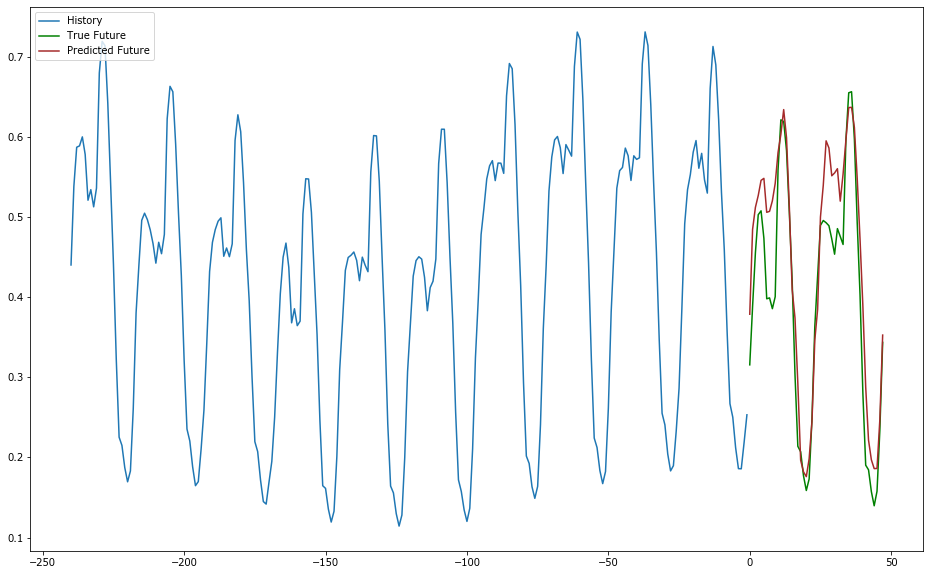

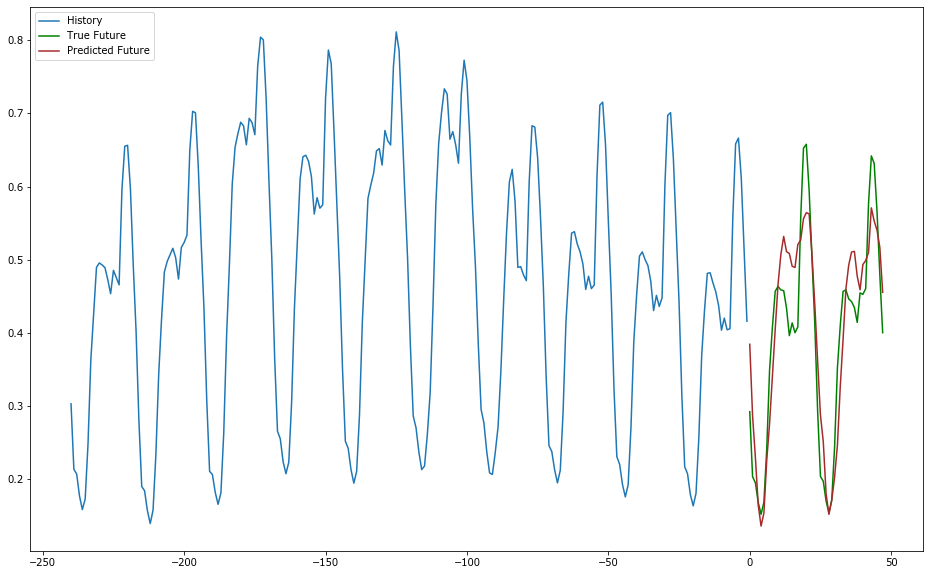

In [119]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multivariate_model.predict(x)[0])

In [120]:
from statsmodels.tools.eval_measures import mse,rmse
def evaluate_LSTM(z,y):
    scores=[]
    for i in range(0,z.shape[0]):
    
        trainPredict_dataset_like=np.zeros(shape=(len(z[i]),3))
        trainPredict_dataset_like[:,1]=z[i]
        Predict=sc.inverse_transform(trainPredict_dataset_like)[:,1]
    
        actual_dataset_like=np.zeros(shape=(len(np.asarray(y[i])),3))
        actual_dataset_like[:,1]=np.asarray(y[i])
        actual=sc.inverse_transform(actual_dataset_like)[:,1]
        scores.append(rmse(Predict,actual))
    
    return scores, sum(scores) / len(scores)

In [121]:
evaluate_LSTM(multivariate_model.predict(x),y)

([326.5234359406932,
  315.69703125150903,
  305.10931873335926,
  298.5319453929649,
  302.12955818791784,
  303.08155014456736,
  315.494620187379,
  315.86326982973804,
  303.68561206401495,
  309.0593130143903,
  336.8338173899193,
  355.80709182931014,
  361.3076015444328,
  391.2975786140223,
  422.1729683937096,
  432.7017161213958,
  466.2444115221487,
  508.75756038254553,
  545.0602054289171,
  603.6841378723284,
  651.766837373919,
  682.2340600520538,
  696.4621006299616,
  704.6982856766082,
  712.4102654980709,
  714.0516011501836,
  708.0012266200539,
  693.4203765876192,
  685.4710583868707,
  690.4110654926409,
  700.8275436761191,
  699.4170469397571,
  682.0133544487446,
  666.816692023616,
  667.9931664929768,
  685.5697659043308,
  714.9784091964694,
  762.1049907889807,
  803.61339516697,
  823.4137884337634,
  852.6678682850026,
  889.9545003427816,
  930.2251366026846,
  979.4320104500077,
  1022.0589222909372,
  1050.023555291628,
  1062.0758038417734,
  1067.3